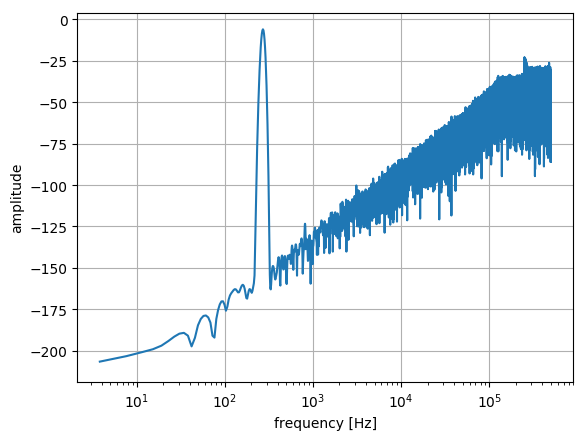

In [191]:
import PyPlot

f_s = 1e6;
T_s = 1/f_s;

n_fft = 2^18;
n_ini = 2^10;
k = 71;

f_i = f_s/n_fft*k;
a_i = .5;
b_i = 0;

n_i = 0;

t = 0:T_s:T_s*(n_fft+n_ini-1);
inp = a_i*sin.(2*pi*f_i*t) + b_i + 2*n_i*(rand(size(t))-.5);

int_1 = zeros(size(t));
int_2 = zeros(size(t));
q_0   = zeros(size(t));

for i = 2:length(inp)
    int_1[i] = int_1[i-1] + (inp[i] - q_0[i-1]);
    int_2[i] = int_2[i-1] + (int_1[i] - q_0[i-1]);
    q_0[i] = (int_2[i] > 0)*2-1;
end

q = q_0[end-n_fft+1:end];

import DSP

w = DSP.Windows.kaiser(n_fft, 20);
wf = mean(w);
Y_inp = fft(q.*w)/n_fft/wf;

f = linspace(0, f_s/2, (n_fft/2+1));

PyPlot.semilogx(f, 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/2+1)])));
PyPlot.grid(true);
PyPlot.xlabel("frequency [Hz]");
PyPlot.ylabel("amplitude");

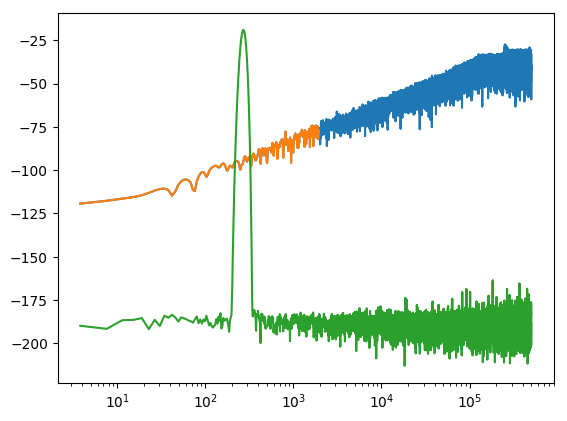

99.82573871732605

In [192]:
b_i = f_i/f_s;
n = n_fft;
    
xs = sin.(2*pi*b_i*(1:n));
xc = cos.(2*pi*b_i*(1:n));
a  = sum(2*xs.*q)/n;
b  = sum(2*xc.*q)/n;
    
i_sig = (a*xs+b*xc);
i_noi = q - i_sig;

w     = DSP.Windows.kaiser(n, 20);
wf    = sum(w)/n;
I_sig = fft(wf*i_sig.*w)/n;
I_noi = fft(wf*i_noi.*w)/n;

bw    = trunc(Int64, n./(256*2));

P_sig = sum(abs.(I_sig[1:bw]).^2);
P_noi = sum(abs.(I_noi[1:bw]).^2);

print(10*log10(P_sig/P_noi))

f = linspace(0, f_s/2, (n_fft/2+1));

PyPlot.semilogx(f[2:end], 10*log10.(2*abs.(I_noi[2:trunc(Int64, n_fft/2+1)])))
PyPlot.hold(true)
PyPlot.semilogx(f[2:bw], 10*log10.(2*abs.(I_noi[2:bw])))
PyPlot.semilogx(f[2:end], 10*log10.(2*abs.(I_sig[2:trunc(Int64, n_fft/2+1)])))
PyPlot.hold(false)

In [201]:
cic_r = 256;
cic_m = 2;
cic_n = 3;

cic_int_1 = zeros(size(q_0));
cic_int_2 = zeros(size(q_0));
cic_int_3 = zeros(size(q_0));
cic_dec   = zeros(length(q_0)/cic_r+1);
cic_dif_1 = zeros(length(q_0)/cic_r+1);
cic_dif_2 = zeros(length(q_0)/cic_r+1);
cic_dif_3 = zeros(length(q_0)/cic_r+1);
t_dec     = zeros(length(q_0)/cic_r+1);

c = 0;
k = cic_m;
for i = 2:length(q_0)
    cic_int_1[i] = cic_int_1[i-1] + q_0[i];
    cic_int_2[i] = cic_int_2[i-1] + cic_int_1[i];
    cic_int_3[i] = cic_int_3[i-1] + cic_int_2[i];
    c = c + 1;
    if c == cic_r
        c = 0;
        k = k + 1;
        t_dec[k] = t[i];
        cic_dec[k] = cic_int_3[i];
        cic_dif_1[k] = cic_dec[k] - cic_dec[k-cic_m];
        cic_dif_2[k] = cic_dif_1[k] - cic_dif_1[k-cic_m];
        cic_dif_3[k] = cic_dif_2[k] - cic_dif_2[k-cic_m];
    end
end

k = (cic_r*cic_m)^cic_n;
cic_out = cic_dif_3[trunc(Int64, end-n_fft/cic_r+1):end]/k;

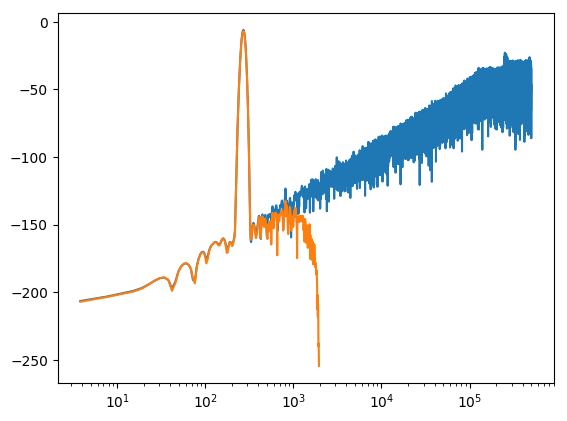

In [204]:
cic_n_fft = trunc(Int64, n_fft/cic_r);
w = DSP.Windows.kaiser(cic_n_fft, 20);
wf = mean(w);
Y_cic = fft(cic_out.*w)/cic_n_fft/wf;

f_cic = linspace(0, f_s/2/cic_r, (cic_n_fft/2+1));

PyPlot.semilogx(f, 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/2+1)])));
PyPlot.hold(true)
PyPlot.semilogx(f_cic, 20*log10.(2*abs.(Y_cic[1:trunc(Int64, cic_n_fft/2+1)])))
PyPlot.hold(false)

snr (generic function with 1 method)